# 01 Clean and Resample SOS Data
### Author: Danny Hogan and Eli Schwat
### Date: Maty 6, 2024

This notebook will clean the SOS eddy covariance data a few different ways and then resample the dataset from 5-minute averages to 1-hour, 3-hour, 6-hour, 12-hour, and 1-day averages/medians/sums. These datasets will then be saved as analysis products.

### Imports


In [1]:
# general
import os
import glob
import datetime as dt
import json
import time
from tqdm import tqdm
from joblib import Parallel, delayed

# data 
import xarray as xr 
from sublimpy import utils, turbulence
import numpy as np
import pandas as pd
# plotting
import matplotlib.pyplot as plt
from metpy import constants as mpconsts
# helper tools
import scripts.helper_funcs as hf
from metpy import calc, units

## 1. Load SOS data
We'll begin by loading up the SOS data and 

In [2]:
# set up the data directory
DATE_FORMAT_STR = '%Y%m%d'
start_date = '20221130'
# end_date = '20230509'
end_date = '20230619'
PLANAR_FIT = False

datelist = pd.date_range(
    dt.datetime.strptime(start_date, DATE_FORMAT_STR),
    dt.datetime.strptime(end_date, DATE_FORMAT_STR),
    freq='d'
).strftime(DATE_FORMAT_STR).tolist()
print(datelist)

['20221130', '20221201', '20221202', '20221203', '20221204', '20221205', '20221206', '20221207', '20221208', '20221209', '20221210', '20221211', '20221212', '20221213', '20221214', '20221215', '20221216', '20221217', '20221218', '20221219', '20221220', '20221221', '20221222', '20221223', '20221224', '20221225', '20221226', '20221227', '20221228', '20221229', '20221230', '20221231', '20230101', '20230102', '20230103', '20230104', '20230105', '20230106', '20230107', '20230108', '20230109', '20230110', '20230111', '20230112', '20230113', '20230114', '20230115', '20230116', '20230117', '20230118', '20230119', '20230120', '20230121', '20230122', '20230123', '20230124', '20230125', '20230126', '20230127', '20230128', '20230129', '20230130', '20230131', '20230201', '20230202', '20230203', '20230204', '20230205', '20230206', '20230207', '20230208', '20230209', '20230210', '20230211', '20230212', '20230213', '20230214', '20230215', '20230216', '20230217', '20230218', '20230219', '20230220', '20

Variable names below:

In [3]:
# Separate out the eddy covariance measurement variable names because they are very repetitive
ec_measurement_suffixes = [
    '1m_ue',    '2m_ue',    '3m_ue',    '10m_ue', 
    '1m_d',     '2m_d',     '3m_d',     '10m_d',
    '1m_uw',    '2m_uw',    '2_5m_uw',  '3m_uw',    '10m_uw', 
    '1m_c',     '2m_c',     '3m_c',     '5m_c',     '10m_c',    '15m_c',    '20m_c'
]

sonic_measurement_prefixes = [
    'u_', 'v_', 'w_', 'tc_', 'spd_', 'dir_', 
    'u_u__', 'v_v__', 'w_w__', 'tc_tc__', 
    'u_w__', 'v_w__', 'u_v__', 
    'u_tc__', 'v_tc__', 'w_tc__', 
    'u_u_u__', 'v_v_v__', 'w_w_w__', 
    'tc_tc_tc__', 
]
irga_measurement_prefixes = [
    'h2o_', 'h2o_h2o__', 'h2o_h2o_h2o__', 
]
sonic_plus_irga_measurement_prefixes = [
    'u_h2o__', 'v_h2o__', 'w_h2o__', 
]
ec_measurement_prefixes = sonic_measurement_prefixes + irga_measurement_prefixes + sonic_plus_irga_measurement_prefixes

ec_variable_names = [
    (prefix + suffix) for prefix in ec_measurement_prefixes for suffix in ec_measurement_suffixes
]

counts_vars = ['counts_' + suffix for suffix in ec_measurement_suffixes]
counts_1_vars = ['counts_' + suffix + '_1' for suffix in ec_measurement_suffixes]
counts_2_vars = ['counts_' + suffix + '_2' for suffix in ec_measurement_suffixes]
irgadiag_vars = ['irgadiag_' + suffix for suffix in ec_measurement_suffixes]
ldiag_vars = ['ldiag_' + suffix for suffix in ec_measurement_suffixes]

diagnostic_variable_names = counts_vars + counts_1_vars + counts_2_vars + irgadiag_vars + ldiag_vars

VARIABLE_NAMES = ec_variable_names + diagnostic_variable_names + [
    # Temperature & Relative Humidity Array 
    'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'RH_1m_c', 'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
    'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

    # Pressure Sensors
    'P_20m_c',
    'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

    # Blowing snow/FlowCapt Sensors
    'SF_avg_1m_ue', 'SF_avg_2m_ue',

    # Apogee sensors
    "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
    "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
    "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

    # Snow-level temperature arrays (towers D and UW)
    'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
    'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
    
    # Downward/Upward Facing Longwave Radiometers
    'Rpile_out_9m_d','Tcase_out_9m_d',    
    'Rpile_in_9m_d', 'Tcase_in_9m_d',
    'Tcase_uw', 'Rpile_in_uw', 'Rpile_out_uw',
    
    # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
    'Rsw_in_9m_d', 'Rsw_out_9m_d', 'Rsw_in_uw', 'Rsw_out_uw',

    # Snow Pillow SWE
    'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c',

    # Soil Moisture
    'Qsoil_d',

    # Ground Heat Flux
    'Gsoil_d',
    
    # Soil Temperature
    'Tsoil_0_6cm_d','Tsoil_3_1cm_d','Tsoil_1_9cm_d','Tsoil_4_4cm_d','Tsoil_8_1cm_d','Tsoil_9_4cm_d','Tsoil_10_6cm_d','Tsoil_11_9cm_d','Tsoil_18_1cm_d',
    'Tsoil_19_4cm_d','Tsoil_20_6cm_d','Tsoil_21_9cm_d','Tsoil_28_1cm_d','Tsoil_29_4cm_d','Tsoil_30_6cm_d','Tsoil_31_9cm_d'
    ]

#### Let's begin by downloading the SOS data and storing it in the /storage/ directory

In [4]:
# Let's begin by downloading the SOS data and storing it in the /storage/ directory
output_dir = '/storage/dlhogan/synoptic_sublimation/sos_data/sosqc/v2'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if 'sosnoqc' in output_dir:
    print("Downloading no qc data")
    sos_5min_ds = utils.download_sos_data(
                            start_date=start_date,
                            end_date=end_date,
                            variable_names=VARIABLE_NAMES,
                            local_download_dir=output_dir,
                            cache=True
                        );  
else:
    if not os.path.exists("./01_data/raw_data/sos_ds_all_storage.nc"):
        print("Creating qc'd data file...")
        start = time.time()
        all_file_paths = [
        os.path.join(
            output_dir,
            f'isfs_sos_qc_geo_tiltcor_5min_{date}.nc'
        ) for date in datelist
        ]
        datasets = []
        for i,file in enumerate(all_file_paths):
            ds = xr.open_dataset(file)
            # this ensures we don't access variables that aren't in this dataset, which would throw an error
            ds_new = ds[set(ds.data_vars).intersection(VARIABLE_NAMES)] # variables.DEFAULT_VARIABLES+hf.WATER_VAPOR_VARIABLES+hf.COUNT_VARIABLES
            datasets.append(ds_new)
            # for every 10th file, print the time between
            if i % 10 == 0:
                print(f"Time elapsed for 10 files: {time.time()-start}")
                start = time.time()
        sos_ds = xr.concat(datasets, dim='time')
        # ensure time index is evernly spaced by filling in missing times
        sos_ds = utils.fill_missing_timestamps(sos_ds)
        sos_ds.to_netcdf("./01_data/raw_data/sos_ds_all_storage.nc")
    else:
        print("Loading qc'd data file...")
        sos_ds = xr.open_dataset("./01_data/raw_data/sos_ds_all_storage.nc")

Loading qc'd data file...


### Now, we'll add the surface temperatures to the dataset. 

In [58]:
SIGMA = 5.67e-8 # W/m^2/K^4
# functions I will need 
def apogee2sensortemp(dat,tower):
# hard-coded sensor-specific calibrations
    Vref = 2.5
    ID = dat[f"IDir_{tower}"]
    sns = [136, 137, 138, 139, 140]
    im = [ sns.index(x) if x in sns else None for x in ID ][0]
# unclear if we want these, or scaled up versions
    mC0 = [57508.575,56653.007,58756.588,58605.7861,58756.588][im] * 1e5
    mC1 = [289.12189,280.03380,287.12487,285.00285,287.12487][im] * 1e5
    mC2 = [2.16807,2.11478,2.11822,2.08932,2.11822][im] * 1e5
    bC0 = [-168.3687,-319.9362,-214.5312,-329.6453,-214.5312][im]* 1e5
    bC1 = [-0.22672,-1.23812,-0.59308,-1.24657,-0.59308][im]* 1e5
    bC2 = [0.08927,0.08612,0.10936,0.09234,0.10936][im]* 1e5
# read data
    Vtherm = dat[f"Vtherm_{tower}"]
    Vpile = dat[f"Vpile_{tower}"]*1000
# calculation of detector temperature from Steinhart-Hart
    Rt = 24900.0/((Vref/Vtherm) - 1)
    Ac = 1.129241e-3
    Bc = 2.341077e-4
    Cc = 8.775468e-8
    TDk = 1/(Ac + Bc*np.log(Rt) + Cc*(np.log(Rt)**3))
    TDc = TDk - 273.15
# finally, calculation of "target" temperature including thermopile measurement
    m = mC2*TDc**2 + mC1*TDc + mC0
    b = bC2*TDc**2 + bC1*TDc + bC0
    TTc = (TDk**4 + m*Vpile + b)**0.25
    # sufs = suffixes(TTc,leadch='') # get suffixes
    # dimnames(TTc)[[2]] = paste0("Tsfc.Ap.",sufs)
    return TTc

def sensortemp2targettemp(dat, tower, bg_radiation, emissivity=0.99):
    """
    This function will perform a emissivity correction to calculate the target temperature from the sensor temperature.
    It will use the blackbody temperature from the downwelling longwave radiation sensor to calculate background temperature.
    It will use an emissivity of 0.99 for the snow surface (Warren, 1982). 
    """
    sensor_temp = apogee2sensortemp(dat, tower)

    # calculate the background temperature
    bg_blackbody_temp = (bg_radiation /SIGMA)**0.25
    # fill in missing values with linear interpolation, up to 12 hours
    bg_blackbody_temp = bg_blackbody_temp.interpolate_na('time', limit=144)
    # calculate the target temperature
    target_temp = ((sensor_temp**4  - (1-emissivity)*(bg_blackbody_temp**4))/emissivity)**0.25
    # convert to celsius, add units
    target_temp = (target_temp - 273.15)*units.units.degC
    return target_temp                         


In [59]:
sos_ds = sos_ds.assign(R_lw_up = ((sos_ds.Rpile_out_9m_d + (sos_ds.Tcase_out_9m_d+273.15)**4*SIGMA)))
sos_ds = sos_ds.assign(R_lw_down = ((sos_ds.Rpile_in_9m_d + (sos_ds.Tcase_in_9m_d+273.15)**4*SIGMA)))
# add surface temperature if not already present
if len([key for key in sos_ds.keys() if 'Tsurfapogee' in key])!=4:
    sos_ds = sos_ds.assign(Tsurfapogee_d=sensortemp2targettemp(sos_ds,'d', sos_ds['R_lw_down']))
    sos_ds = sos_ds.assign(Tsurfapogee_c=sensortemp2targettemp(sos_ds,'c',sos_ds['R_lw_down']))
    sos_ds = sos_ds.assign(Tsurfapogee_uw=sensortemp2targettemp(sos_ds,'uw',sos_ds['R_lw_down']))
    sos_ds = sos_ds.assign(Tsurfapogee_ue=sensortemp2targettemp(sos_ds,'ue',sos_ds['R_lw_down']))

### We'll now replace the sonic anemometer and IRGAson flags with [Eli's calculations](https://github.com/elischwat/sublimationofsnow/blob/master/analysis/paper1/process_slow_data/create_turbulence_dataset_30min_straightup.py)

In [60]:
flag_counts_df = pd.read_parquet("./01_data/raw_data/sosqc_fast_flagcounts/").loc[start_date: end_date]
assert all(sos_ds.time == flag_counts_df.index)

In [61]:
irga_vars = [
    'irgadiag_10m_c',	 'irgadiag_10m_d',	 'irgadiag_10m_ue',	 'irgadiag_10m_uw',	 'irgadiag_15m_c',	 'irgadiag_1m_c',	 'irgadiag_1m_d',	 'irgadiag_1m_ue',	 
    'irgadiag_1m_uw',	 'irgadiag_20m_c',	 'irgadiag_2m_c',	 'irgadiag_3m_c',	 'irgadiag_3m_d',	 'irgadiag_3m_ue',	 'irgadiag_3m_uw',	 'irgadiag_5m_c',	
]

ldiag_vars = [
    'ldiag_10m_c', 'ldiag_10m_d', 'ldiag_10m_ue', 'ldiag_10m_uw', 'ldiag_15m_c', 'ldiag_1m_c', 'ldiag_1m_d', 'ldiag_1m_ue', 
    'ldiag_1m_uw', 'ldiag_20m_c', 'ldiag_2m_c', 'ldiag_3m_c', 'ldiag_3m_d', 'ldiag_3m_ue', 'ldiag_3m_uw', 'ldiag_5m_c',
]

for var in irga_vars + ldiag_vars:
    sos_ds[var] = flag_counts_df[var]

## Now we will begin the process of resampling

### First, we separate which variables need to be reynolds averaged, median, averaged, and summed
All EC variables will be reynolds averaged up to 1-hour. From there, all other resampling will be built off of the 1-hour Reynold's averaged values. All normal met variables, except wind direction will be averaged. Wind direction will be median. This will eventually be replaced with the average 

In [78]:
data_vars_processing_dict = {
    'reynolds_average': [
        'u_u__1m_uw',    'v_v__1m_uw',    'w_w__1m_uw',    'u_w__1m_uw',    'v_w__1m_uw',  'u_tc__1m_uw',  'v_tc__1m_uw',   'u_h2o__1m_uw',  'v_h2o__1m_uw',   'w_tc__1m_uw',   'w_h2o__1m_uw',
        'u_u__2m_uw',    'v_v__2m_uw',    'w_w__2m_uw',    'u_w__2m_uw',    'v_w__2m_uw',  'u_tc__2m_uw',  'v_tc__2m_uw',   'u_h2o__2m_uw',  'v_h2o__2m_uw',   'w_tc__2m_uw',   'w_h2o__2m_uw',
        'u_u__2_5m_uw', 'v_v__2_5m_uw',   'w_w__2_5m_uw',  'u_w__2_5m_uw',  'v_w__2_5m_uw','u_tc__2_5m_uw','v_tc__2_5m_uw', 'u_h2o__2_5m_uw','v_h2o__2_5m_uw', 'w_tc__2_5m_uw', 'w_h2o__2_5m_uw',
        'u_u__3m_uw',    'v_v__3m_uw',    'w_w__3m_uw',    'u_w__3m_uw',    'v_w__3m_uw',  'u_tc__3m_uw',  'v_tc__3m_uw',   'u_h2o__3m_uw',  'v_h2o__3m_uw',   'w_tc__3m_uw',   'w_h2o__3m_uw',
        'u_u__10m_uw',   'v_v__10m_uw',   'w_w__10m_uw',   'u_w__10m_uw',   'v_w__10m_uw', 'u_tc__10m_uw', 'v_tc__10m_uw',  'u_h2o__10m_uw', 'v_h2o__10m_uw',  'w_tc__10m_uw',  'w_h2o__10m_uw',
        'u_u__1m_ue',    'v_v__1m_ue',    'w_w__1m_ue',    'u_w__1m_ue',    'v_w__1m_ue',  'u_tc__1m_ue',  'v_tc__1m_ue',   'u_h2o__1m_ue',  'v_h2o__1m_ue',   'w_tc__1m_ue',   'w_h2o__1m_ue',
        'u_u__2m_ue',    'v_v__2m_ue',    'w_w__2m_ue',    'u_w__2m_ue',    'v_w__2m_ue',  'u_tc__2m_ue',  'v_tc__2m_ue',   'u_h2o__2m_ue',  'v_h2o__2m_ue',   'w_tc__2m_ue',   'w_h2o__2m_ue',
        'u_u__3m_ue',    'v_v__3m_ue',    'w_w__3m_ue',    'u_w__3m_ue',    'v_w__3m_ue',  'u_tc__3m_ue',  'v_tc__3m_ue',   'u_h2o__3m_ue',  'v_h2o__3m_ue',   'w_tc__3m_ue',   'w_h2o__3m_ue',
        'u_u__10m_ue',   'v_v__10m_ue',   'w_w__10m_ue',   'u_w__10m_ue',   'v_w__10m_ue', 'u_tc__10m_ue', 'v_tc__10m_ue',  'u_h2o__10m_ue', 'v_h2o__10m_ue',  'w_tc__10m_ue',  'w_h2o__10m_ue',
        'u_u__1m_d',     'v_v__1m_d',     'w_w__1m_d',     'u_w__1m_d',     'v_w__1m_d',   'u_tc__1m_d',   'v_tc__1m_d',    'u_h2o__1m_d',   'v_h2o__1m_d',    'w_tc__1m_d',    'w_h2o__1m_d',
        'u_u__2m_d',     'v_v__2m_d',     'w_w__2m_d',     'u_w__2m_d',     'v_w__2m_d',   'u_tc__2m_d',   'v_tc__2m_d',    'u_h2o__2m_d',   'v_h2o__2m_d',    'w_tc__2m_d',    'w_h2o__2m_d',
        'u_u__3m_d',     'v_v__3m_d',     'w_w__3m_d',     'u_w__3m_d',     'v_w__3m_d',   'u_tc__3m_d',   'v_tc__3m_d',    'u_h2o__3m_d',   'v_h2o__3m_d',    'w_tc__3m_d',    'w_h2o__3m_d',
        'u_u__10m_d',    'v_v__10m_d',    'w_w__10m_d',    'u_w__10m_d',    'v_w__10m_d',  'u_tc__10m_d',  'v_tc__10m_d',   'u_h2o__10m_d',  'v_h2o__10m_d',   'w_tc__10m_d',   'w_h2o__10m_d',
        'u_u__1m_c',     'v_v__1m_c',     'w_w__1m_c',     'u_w__1m_c',     'v_w__1m_c',   'u_tc__1m_c',   'v_tc__1m_c',    'u_h2o__1m_c',   'v_h2o__1m_c',    'w_tc__1m_c',    'w_h2o__1m_c',
        'u_u__2m_c',     'v_v__2m_c',     'w_w__2m_c',     'u_w__2m_c',     'v_w__2m_c',   'u_tc__2m_c',   'v_tc__2m_c',    'u_h2o__2m_c',   'v_h2o__2m_c',    'w_tc__2m_c',    'w_h2o__2m_c',
        'u_u__3m_c',     'v_v__3m_c',     'w_w__3m_c',     'u_w__3m_c',     'v_w__3m_c',   'u_tc__3m_c',   'v_tc__3m_c',    'u_h2o__3m_c',   'v_h2o__3m_c',    'w_tc__3m_c',    'w_h2o__3m_c',
        'u_u__5m_c',     'v_v__5m_c',     'w_w__5m_c',     'u_w__5m_c',     'v_w__5m_c',   'u_tc__5m_c',   'v_tc__5m_c',    'u_h2o__5m_c',   'v_h2o__5m_c',    'w_tc__5m_c',    'w_h2o__5m_c',
        'u_u__10m_c',    'v_v__10m_c',    'w_w__10m_c',    'u_w__10m_c',    'v_w__10m_c',  'u_tc__10m_c',  'v_tc__10m_c',   'u_h2o__10m_c',  'v_h2o__10m_c',   'w_tc__10m_c',   'w_h2o__10m_c',
        'u_u__15m_c',    'v_v__15m_c',    'w_w__15m_c',    'u_w__15m_c',    'v_w__15m_c',  'u_tc__15m_c',  'v_tc__15m_c',   'u_h2o__15m_c',  'v_h2o__15m_c',   'w_tc__15m_c',   'w_h2o__15m_c',
        'u_u__20m_c',    'v_v__20m_c',    'w_w__20m_c',    'u_w__20m_c',    'v_w__20m_c',  'u_tc__20m_c',  'v_tc__20m_c',   'u_h2o__20m_c',  'v_h2o__20m_c',   'w_tc__20m_c',   'w_h2o__20m_c',
    ],
    'average': [
        # Sonic anemometer data
        'h2o_1m_uw' ,       'tc_1m_uw',     'spd_1m_uw',    'u_1m_uw',  'v_1m_uw',   'w_1m_uw',  
        'h2o_3m_uw' ,       'tc_3m_uw',     'spd_3m_uw',    'u_3m_uw',  'v_3m_uw',   'w_3m_uw',  
        'h2o_10m_uw' ,      'tc_10m_uw',    'spd_10m_uw',   'u_10m_uw', 'v_10m_uw',  'w_10m_uw',  
        'h2o_1m_ue' ,       'tc_1m_ue',     'spd_1m_ue',    'u_1m_ue',  'v_1m_ue',   'w_1m_ue',  
        'h2o_3m_ue' ,       'tc_3m_ue',     'spd_3m_ue',    'u_3m_ue',  'v_3m_ue',   'w_3m_ue',  
        'h2o_10m_ue' ,      'tc_10m_ue',    'spd_10m_ue',   'u_10m_ue', 'v_10m_ue',  'w_10m_ue',  
        'h2o_1m_d' ,        'tc_1m_d',      'spd_1m_d',     'u_1m_d',   'v_1m_d',    'w_1m_d',  
        'h2o_3m_d' ,        'tc_3m_d',      'spd_3m_d',     'u_3m_d',   'v_3m_d',    'w_3m_d',  
        'h2o_10m_d' ,       'tc_10m_d',     'spd_10m_d',    'u_10m_d',  'v_10m_d',   'w_10m_d',  
        'h2o_2m_c' ,        'tc_2m_c',      'spd_2m_c',     'u_2m_c',   'v_2m_c',    'w_2m_c',  
        'h2o_3m_c' ,        'tc_3m_c',      'spd_3m_c',     'u_3m_c',   'v_3m_c',    'w_3m_c',  
        'h2o_5m_c' ,        'tc_5m_c',      'spd_5m_c',     'u_5m_c',   'v_5m_c',    'w_5m_c',  
        'h2o_10m_c' ,       'tc_10m_c',     'spd_10m_c',    'u_10m_c',  'v_10m_c',   'w_10m_c',  
        'h2o_15m_c' ,       'tc_15m_c',     'spd_15m_c',    'u_15m_c',  'v_15m_c',   'w_15m_c',  
        'h2o_20m_c' ,       'tc_20m_c',     'spd_20m_c',    'u_20m_c',  'v_20m_c',   'w_20m_c',  

        # Temperature & Relative Humidity Array 
        'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
        'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

        'RH_1m_c', 'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
        'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

        # Pressure Sensors
        'P_20m_c',
        'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

        # Blowing snow/FlowCapt Sensors
        'SF_avg_1m_ue', 'SF_avg_2m_ue',

        # Apogee sensors
        "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
        "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
        "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",
        "Tsurfapogee_d", "Tsurfapogee_c", "Tsurfapogee_uw", "Tsurfapogee_ue",

        # Snow-level temperature arrays (towers D and UW)
        'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
        'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
        
        # Downward Facing Longwave Radiometer (tower D) - for measuring snow surface temperature
        'Rpile_out_9m_d',
        'Tcase_out_9m_d',    
        'R_lw_up',
        # Upward Facing Longwave Radiometer (tower D)
        'Rpile_in_9m_d',
        'Tcase_in_9m_d',
        'R_lw_down',
        # Downward Facing Longwave Radiometer (tower UW) - for measuring snow surface temperature
        'Tcase_uw', 'Rpile_in_uw', 'Rpile_out_uw',
        
        # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
        'Rsw_in_9m_d',
        'Rsw_out_9m_d',

        # Snow Pillow SWE
        'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c',

        # Soil Moisture
        'Qsoil_d',

        # Soil heat flux
        # 'Gsoil_d',
        
        # Diagnostic variables for irga and sonic
        'irgadiag_1m_c',    'ldiag_1m_c',
        'irgadiag_2m_c',    'ldiag_2m_c',
        'irgadiag_3m_c',    'ldiag_3m_c',
        'irgadiag_5m_c',    'ldiag_5m_c',
        'irgadiag_10m_c',   'ldiag_10m_c',
        'irgadiag_15m_c',   'ldiag_15m_c',
        'irgadiag_20m_c',   'ldiag_20m_c',
        'irgadiag_1m_uw',   'ldiag_1m_uw',
        'irgadiag_3m_uw',   'ldiag_3m_uw',
        'irgadiag_10m_uw',  'ldiag_10m_uw',
        'irgadiag_1m_ue',   'ldiag_1m_ue',
        'irgadiag_3m_ue',   'ldiag_3m_ue',
        'irgadiag_10m_ue',  'ldiag_10m_ue',
        'irgadiag_1m_d',    'ldiag_1m_d',
        'irgadiag_3m_d',    'ldiag_3m_d',
        'irgadiag_10m_d',   'ldiag_10m_d',

    ],
    'median' : [
        'dir_1m_uw',    
        'dir_3m_uw',    
        'dir_10m_uw',   
        'dir_1m_ue',    
        'dir_3m_ue',    
        'dir_10m_ue',   
        'dir_1m_d',     
        'dir_3m_d',     
        'dir_10m_d',    
        'dir_2m_c',     
        'dir_3m_c',     
        'dir_5m_c',     
        'dir_10m_c',    
        'dir_15m_c',    
        'dir_20m_c',    
    ],
    'sum' : [
        # Counts of unflagged instantaneous (20hz) eddy covariance measurements
        # momentum flux flags   LHFlux flags   SH flux flags       
        'counts_1m_c',    'counts_1m_c_1',    'counts_1m_c_2',    
        'counts_2m_c',    'counts_2m_c_1',    'counts_2m_c_2',    
        'counts_3m_c',    'counts_3m_c_1',    'counts_3m_c_2',    
        'counts_5m_c',    'counts_5m_c_1',    'counts_5m_c_2',    
        'counts_10m_c',   'counts_10m_c_1',   'counts_10m_c_2',   
        'counts_15m_c',   'counts_15m_c_1',   'counts_15m_c_2',   
        'counts_20m_c',   'counts_20m_c_1',   'counts_20m_c_2',   
        'counts_1m_uw',   'counts_1m_uw_1',   'counts_1m_uw_2',   
        'counts_3m_uw',   'counts_3m_uw_1',   'counts_3m_uw_2',   
        'counts_10m_uw',  'counts_10m_uw_1',  'counts_10m_uw_2',  
        # # # 'counts_1m_ue',   'counts_1m_ue_1',   'counts_1m_ue_2',   
        'counts_3m_ue',   'counts_3m_ue_1',   'counts_3m_ue_2',   
        'counts_10m_ue',  'counts_10m_ue_1',  'counts_10m_ue_2',  
        'counts_1m_d',    'counts_1m_d_1',    'counts_1m_d_2',    
        'counts_3m_d',    'counts_3m_d_1',    'counts_3m_d_2',    
        'counts_10m_d',   'counts_10m_d_1',   'counts_10m_d_2',   
    ]
}

### Next, we remove instrument-flagged data
Based on Stiperski and Rotach (2016, http://link.springer.com/10.1007/s10546-015-0103-z), who recommend the following steps as minimum quality criteria:

The sonic diagnostic flag was set high (malfunctioning of the instrument) inside the averaging period.
KH20 voltage fell below 5 mV (indication of condensation occurring on the KH20 window).
Skewness of temperature and wind components fell outside the [-2, 2] range, following Vickers and Mahrt (1997).
Kurtosis of temperature and wind components was >8, following Vickers and Mahrt (1997).


Here, we only implement number #2 and #3. We tried implementing #1, using the ldiag flag to remove sonic data, but it removed a lot of data, and, without using high rate data, we't cannot filter based on a "high" diagnostic flag, we can only filtering using the aggregate of all the flags (i.e. ldiag > 0). The 4th moments are not included in the 5-minute averages, so we cannot implement #4 without using the high rate data.

### Set bad Irga measurements to NaN
The NCAR report recommends all Irga-related measurements be set to NaN when irgadiag is non-zero. They did this for some but not all of the data.

In [79]:
print('h2o_flux_var', 'irgadiag_var', 'old_nan_count_badirga', 'new_nan_count_badirga', 'old_mean', 'new_mean')
var_ls = []
old_nan_count_badirga_ls = []
new_nan_count_badirga_ls = []
old_mean_ls = []
new_mean_ls = []
old_median_ls = []
new_median_ls = []
for suffix in ec_measurement_suffixes:
    h2o_flux_var = 'w_h2o__' + suffix
    irgadiag_var = 'irgadiag_' + suffix
     
    old_nan_count_badirga = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
    old_mean = sos_ds[h2o_flux_var].mean().item()
    old_median = sos_ds[h2o_flux_var].median().item()

    # Here, we gather 75% of valid measurements in each 5-minute window
    for prefix in ec_measurement_prefixes:
        var = prefix + suffix
        if var in sos_ds:
            sos_ds[var] = sos_ds[var].where(sos_ds[irgadiag_var] <= 1500)
    # for prefix in [
    #     'h2o_', 'h2o_h2o__', 'u_h2o__', 'v_h2o__', 'w_h2o__',
    #     # I'M NOT SURE I WANT TO REMOVE THESE w_ MEASUREMENTS BUT I"M CURIOUS WHAT HAPPENS IF I DO
    #     'w_',
    # ]:


    new_nan_count_badirga = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
    new_mean = sos_ds[h2o_flux_var].mean().item()
    new_median = sos_ds[h2o_flux_var].median().item()
    print(h2o_flux_var, irgadiag_var, old_nan_count_badirga, new_nan_count_badirga, round(old_mean,6), round(new_mean,6))
    var_ls.append(h2o_flux_var)
    old_nan_count_badirga_ls.append(old_nan_count_badirga)
    new_nan_count_badirga_ls.append(new_nan_count_badirga)
    old_mean_ls.append(old_mean)
    new_mean_ls.append(new_mean)
    old_median_ls.append(old_median)
    new_median_ls.append(new_median)

h2o_flux_var irgadiag_var old_nan_count_badirga new_nan_count_badirga old_mean new_mean
w_h2o__1m_ue irgadiag_1m_ue 41359 41684 0.012494 0.012741
w_h2o__2m_ue irgadiag_2m_ue 26254 26836 0.003897 0.003898
w_h2o__3m_ue irgadiag_3m_ue 5805 6568 0.006271 0.006355
w_h2o__10m_ue irgadiag_10m_ue 5068 5699 0.005967 0.005974
w_h2o__1m_d irgadiag_1m_d 40913 41082 0.011585 0.011705
w_h2o__2m_d irgadiag_2m_d 27853 28318 0.003385 0.003466
w_h2o__3m_d irgadiag_3m_d 5851 6643 0.006573 0.006681
w_h2o__10m_d irgadiag_10m_d 5299 6015 0.006187 0.006255
w_h2o__1m_uw irgadiag_1m_uw 45568 45634 0.016327 0.016416
w_h2o__2m_uw irgadiag_2m_uw 33766 34110 0.003249 0.00325
w_h2o__2_5m_uw irgadiag_2_5m_uw 49376 49565 0.001943 0.002122
w_h2o__3m_uw irgadiag_3m_uw 5302 6022 0.006107 0.006185
w_h2o__10m_uw irgadiag_10m_uw 5999 6819 0.006522 0.00647
w_h2o__1m_c irgadiag_1m_c 28261 28747 0.008657 0.008799
w_h2o__2m_c irgadiag_2m_c 4315 5045 0.005818 0.005905
w_h2o__3m_c irgadiag_3m_c 3635 4288 0.007163 0.007205
w_h2o_

Now, let's visualize what those changes did.

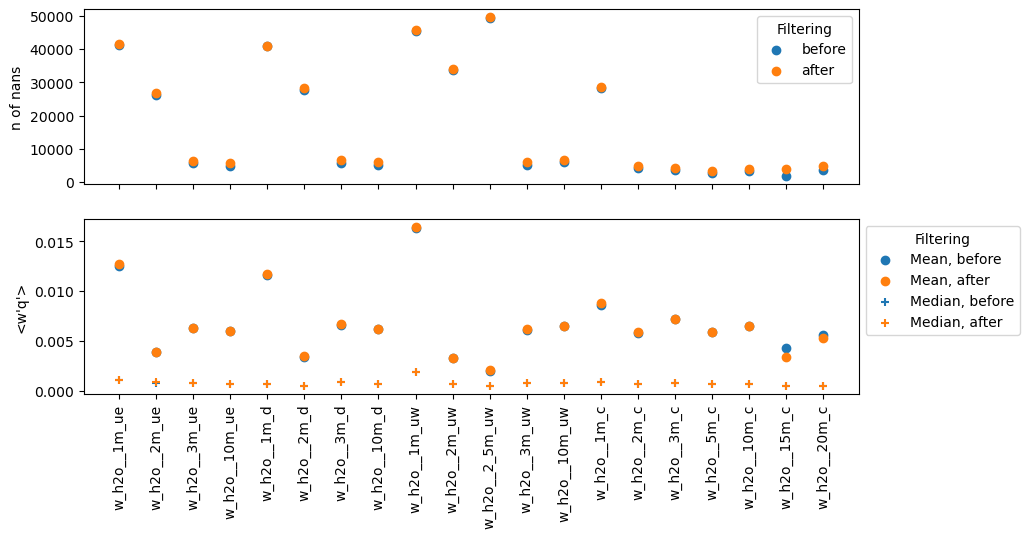

In [80]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(10,5))
axes[0].scatter(var_ls, old_nan_count_badirga_ls, label = 'before', color='tab:blue')
axes[0].set_ylabel("n of nans")
axes[0].scatter(var_ls, new_nan_count_badirga_ls, label = 'after', color='tab:orange')

axes[1].scatter(var_ls, old_mean_ls, label = 'Mean, before', color='tab:blue')
axes[1].set_ylabel("<w'q'>")
axes[1].scatter(var_ls, new_mean_ls, label = 'Mean, after', color='tab:orange')

axes[1].scatter(var_ls, old_median_ls, label = 'Median, before', marker='+', color='tab:blue')
axes[1].set_ylabel("<w'q'>")
axes[1].scatter(var_ls, new_median_ls, label = 'Median, after', marker='+', color='tab:orange')

for ax in axes:
    ax.tick_params(rotation=90, axis='x')
    ax.legend(title='Filtering', bbox_to_anchor=(1,1))

We see minimal changes accross the voard, except for a few locations which show some larger changes. These are locations generally with more nans. Median values remained relatively consistent after filtering while the mean values changed to a greater degree when filtering. 

### Set bad Sonic measurements to Nan

In [81]:
print('h2o_flux_var', 'ldiag_var', 'old_nan_count_badsonic', 'new_nan_count_badsonic', 'old_mean', 'new_mean')

var_ls = []
old_nan_count_badsonic_ls = []
new_nan_count_badsonic_ls = []
old_mean_ls = []
new_mean_ls = []
for suffix in ec_measurement_suffixes:
    w_var = 'w_' + suffix
    h2o_flux_var = 'w_h2o__' + suffix
    sonicdiag_var = 'ldiag_' + suffix
    old_nan_count_badsonic = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
    old_mean = sos_ds[h2o_flux_var].mean().item()
    
    # sos_ds[h2o_flux_var] = sos_ds[h2o_flux_var].where(sos_ds[sonicdiag_var] == 0)
    # sos_ds[w_var] = sos_ds[w_var].where(sos_ds[sonicdiag_var] == 0)
    for prefix in ec_measurement_prefixes:
        var = prefix + suffix
        if var in sos_ds:
            sos_ds[var] = sos_ds[var].where(sos_ds[sonicdiag_var] <= 1500)

    new_nan_count_badsonic = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
    new_mean = sos_ds[h2o_flux_var].mean().item()
    print(h2o_flux_var, sonicdiag_var, old_nan_count_badsonic, new_nan_count_badsonic, round(old_mean,6), round(new_mean,6))
    var_ls.append(h2o_flux_var)
    old_nan_count_badsonic_ls.append(old_nan_count_badsonic)
    new_nan_count_badsonic_ls.append(new_nan_count_badsonic)
    old_mean_ls.append(old_mean)
    new_mean_ls.append(new_mean)

h2o_flux_var ldiag_var old_nan_count_badsonic new_nan_count_badsonic old_mean new_mean
w_h2o__1m_ue ldiag_1m_ue 41684 41684 0.012741 0.012741
w_h2o__2m_ue ldiag_2m_ue 26836 26836 0.003898 0.003898


w_h2o__3m_ue ldiag_3m_ue 6568 6568 0.006355 0.006355
w_h2o__10m_ue ldiag_10m_ue 5699 5699 0.005974 0.005974
w_h2o__1m_d ldiag_1m_d 41082 41082 0.011705 0.011705
w_h2o__2m_d ldiag_2m_d 28318 28318 0.003466 0.003466
w_h2o__3m_d ldiag_3m_d 6643 6643 0.006681 0.006681
w_h2o__10m_d ldiag_10m_d 6015 6015 0.006255 0.006255
w_h2o__1m_uw ldiag_1m_uw 45634 45634 0.016416 0.016416
w_h2o__2m_uw ldiag_2m_uw 34110 34110 0.00325 0.00325
w_h2o__2_5m_uw ldiag_2_5m_uw 49565 49565 0.002122 0.002122
w_h2o__3m_uw ldiag_3m_uw 6022 6022 0.006185 0.006185
w_h2o__10m_uw ldiag_10m_uw 6819 6819 0.00647 0.00647
w_h2o__1m_c ldiag_1m_c 28747 28938 0.008799 0.00879
w_h2o__2m_c ldiag_2m_c 5045 5045 0.005905 0.005905
w_h2o__3m_c ldiag_3m_c 4288 4484 0.007205 0.007186
w_h2o__5m_c ldiag_5m_c 3288 3288 0.005888 0.005888
w_h2o__10m_c ldiag_10m_c 3909 3909 0.006537 0.006537
w_h2o__15m_c ldiag_15m_c 4112 4112 0.00337 0.00337
w_h2o__20m_c ldiag_20m_c 4828 4828 0.005275 0.005275


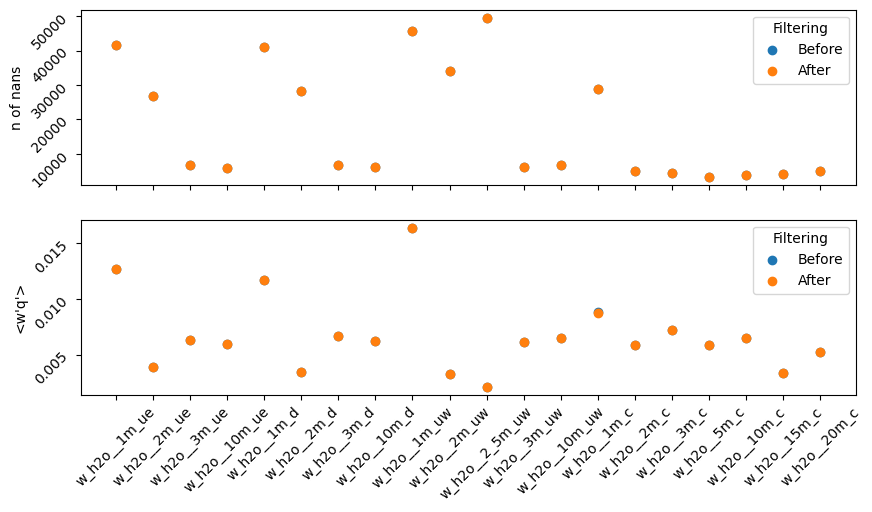

In [82]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(10,5))
axes[0].scatter(var_ls, old_nan_count_badsonic_ls, label = 'Before')
axes[0].set_ylabel("n of nans")
axes[0].scatter(var_ls, new_nan_count_badsonic_ls, label = 'After')

axes[1].scatter(var_ls, old_mean_ls, label = 'Before')
axes[1].set_ylabel("<w'q'>")
axes[1].scatter(var_ls, new_mean_ls, label = 'After')

for ax in axes:
    ax.tick_params(rotation=45)
    ax.legend(title='Filtering')

### Interpolate missing EC variables up to 1 hour

In [83]:
print('h2o_flux_var', 'ldiag_var', 'old_nan_count_afterfilling', 'new_nan_count_afterfilling', 'old_mean', 'new_mean')

var_ls = []
old_nan_count_afterfilling_ls = []
new_nan_count_afterfilling_ls = []
old_mean_ls = []
new_mean_ls = []
for suffix in ec_measurement_suffixes:
    w_var = 'w_' + suffix
    h2o_flux_var = 'w_h2o__' + suffix
    sonicdiag_var = 'ldiag_' + suffix
    old_nan_count_afterfilling = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
    old_mean = sos_ds[h2o_flux_var].mean().item()
    
    for prefix in ec_measurement_prefixes:
        var = prefix + suffix
        if var in sos_ds:
            sos_ds[var] = sos_ds[var].interpolate_na(dim='time', method='linear', limit=12)

    new_nan_count_afterfilling = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
    new_mean = sos_ds[h2o_flux_var].mean().item()
    print(h2o_flux_var, sonicdiag_var, old_nan_count_afterfilling, new_nan_count_afterfilling, round(old_mean,6), round(new_mean,6))
    var_ls.append(h2o_flux_var)
    old_nan_count_afterfilling_ls.append(old_nan_count_afterfilling)
    new_nan_count_afterfilling_ls.append(new_nan_count_afterfilling)
    old_mean_ls.append(old_mean)
    new_mean_ls.append(new_mean)

h2o_flux_var ldiag_var old_nan_count_afterfilling new_nan_count_afterfilling old_mean new_mean


w_h2o__1m_ue ldiag_1m_ue 41684 41077 0.012741 0.01251
w_h2o__2m_ue ldiag_2m_ue 26836 26083 0.003898 0.003879
w_h2o__3m_ue ldiag_3m_ue 6568 4739 0.006355 0.006826
w_h2o__10m_ue ldiag_10m_ue 5699 3982 0.005974 0.00643
w_h2o__1m_d ldiag_1m_d 41082 40675 0.011705 0.011588
w_h2o__2m_d ldiag_2m_d 28318 27812 0.003466 0.003383
w_h2o__3m_d ldiag_3m_d 6643 4939 0.006681 0.006976
w_h2o__10m_d ldiag_10m_d 6015 4384 0.006255 0.006548
w_h2o__1m_uw ldiag_1m_uw 45634 45237 0.016416 0.016037
w_h2o__2m_uw ldiag_2m_uw 34110 33597 0.00325 0.00323
w_h2o__2_5m_uw ldiag_2_5m_uw 49565 49335 0.002122 0.001907
w_h2o__3m_uw ldiag_3m_uw 6022 4330 0.006185 0.006773
w_h2o__10m_uw ldiag_10m_uw 6819 5151 0.00647 0.006707
w_h2o__1m_c ldiag_1m_c 28938 28226 0.00879 0.008659
w_h2o__2m_c ldiag_2m_c 5045 3600 0.005905 0.006471
w_h2o__3m_c ldiag_3m_c 4484 3575 0.007186 0.007157
w_h2o__5m_c ldiag_5m_c 3288 2079 0.005888 0.006547
w_h2o__10m_c ldiag_10m_c 3909 2665 0.006537 0.007047
w_h2o__15m_c ldiag_15m_c 4112 1353 0.00337

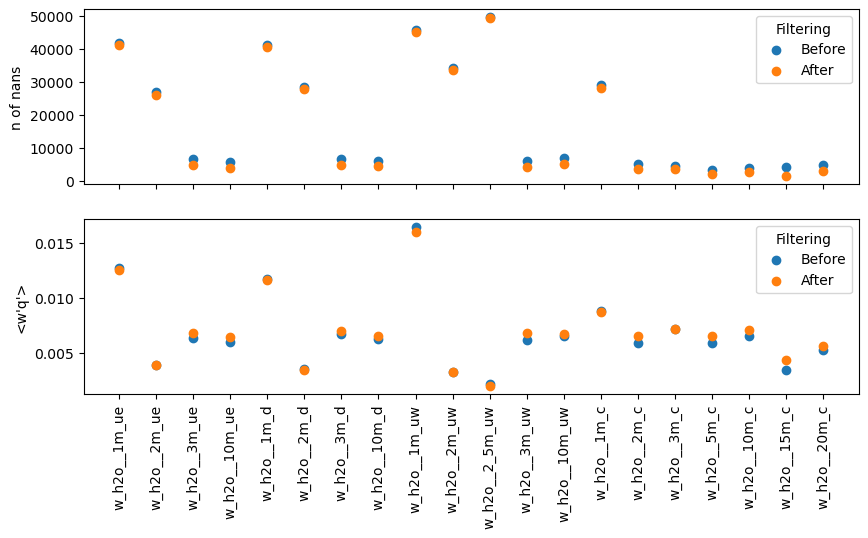

In [84]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(10,5))
axes[0].scatter(var_ls, old_nan_count_afterfilling_ls, label = 'Before')
axes[0].set_ylabel("n of nans")
axes[0].scatter(var_ls, new_nan_count_afterfilling_ls, label = 'After')

axes[1].scatter(var_ls, old_mean_ls, label = 'Before')
axes[1].set_ylabel("<w'q'>")
axes[1].scatter(var_ls, new_mean_ls, label = 'After')

for ax in axes:
    ax.tick_params(axis='x', rotation=90)
    ax.legend(title='Filtering')

Generally, this decreases the mean values and decreases number of nans.

### Now, let's summarize these changes

In [85]:
nan_counts_df = pd.DataFrame({
    'variable':                     var_ls,
    'n':                            len(sos_ds.time),
    'original nan count':           old_nan_count_badirga_ls, 
    'nans after bad irga removed':  new_nan_count_badirga_ls, 
    'nans after bad sonic removed': new_nan_count_badsonic_ls, 
    'nans after gap filling':       new_nan_count_afterfilling_ls,
})
limited_nan_counts_df = nan_counts_df[ 
    (~nan_counts_df.variable.str.contains('__1m_'))
    
    &
    (~nan_counts_df.variable.str.contains('__2_5m_'))
]
limited_nan_counts_df

,variable,n,original nan count,nans after bad irga removed,nans after bad sonic removed,nans after gap filling
1,w_h2o__2m_ue,58176,26254,26836,26836,26083
2,w_h2o__3m_ue,58176,5805,6568,6568,4739
3,w_h2o__10m_ue,58176,5068,5699,5699,3982
5,w_h2o__2m_d,58176,27853,28318,28318,27812
6,w_h2o__3m_d,58176,5851,6643,6643,4939
7,w_h2o__10m_d,58176,5299,6015,6015,4384
9,w_h2o__2m_uw,58176,33766,34110,34110,33597
11,w_h2o__3m_uw,58176,5302,6022,6022,4330
12,w_h2o__10m_uw,58176,5999,6819,6819,5151
14,w_h2o__2m_c,58176,4315,5045,5045,3600


### And we'll separate the reasons for these different flags. Note that the 1m sonics are removed.

In [86]:

limited_nan_counts_df['Data removed by EC150 flag'] = limited_nan_counts_df['nans after bad irga removed'] - limited_nan_counts_df['original nan count']
limited_nan_counts_df['Data removed by CSAT3 flag'] = limited_nan_counts_df['nans after bad sonic removed'] - limited_nan_counts_df['nans after bad irga removed']
limited_nan_counts_df[[
    'variable',
    'n',
    'Data removed by EC150 flag',
    'Data removed by CSAT3 flag'
]]

/tmp/ipykernel_22046/940768610.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_nan_counts_df['Data removed by EC150 flag'] = limited_nan_counts_df['nans after bad irga removed'] - limited_nan_counts_df['original nan count']
/tmp/ipykernel_22046/940768610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_nan_counts_df['Data removed by CSAT3 flag'] = limited_nan_counts_df['nans after bad sonic removed'] - limited_nan_counts_df['nans after bad irga removed']


,variable,n,Data removed by EC150 flag,Data removed by CSAT3 flag
1,w_h2o__2m_ue,58176,582,0
2,w_h2o__3m_ue,58176,763,0
3,w_h2o__10m_ue,58176,631,0
5,w_h2o__2m_d,58176,465,0
6,w_h2o__3m_d,58176,792,0
7,w_h2o__10m_d,58176,716,0
9,w_h2o__2m_uw,58176,344,0
11,w_h2o__3m_uw,58176,720,0
12,w_h2o__10m_uw,58176,820,0
14,w_h2o__2m_c,58176,730,0


## Let's further clean the eddy-covariance data by removing bad values from the dataset.
Drop values outside of 5 standard deviations from the mean

In [87]:
def clean_covariance(ds, tower, height):
    # Written by Eli Schwat
    # print the mean before cleaning for the w_h2o__{height}m_{tower} variable
    print(f"mean before cleaning for w_h2o__{height}m_{tower}: {ds[f'w_h2o__{height}m_{tower}'].mean().values}")
    cleaned = turbulence.clean_eddy_covariance(
                                                ds[f'w_h2o__{height}m_{tower}'].values,
                                                ds[f'counts_{height}m_{tower}'].values,
                                                lower_threshold=np.nanmean(ds[f'w_h2o__{height}m_{tower}'].values)-(np.nanstd(ds[f'w_h2o__{height}m_{tower}'].values) * 5),
                                                upper_threshold=np.nanmean(ds[f'w_h2o__{height}m_{tower}'].values)+(np.nanstd(ds[f'w_h2o__{height}m_{tower}'].values) * 5),
                                            )
    # print the new cleaned mean
    print(f"mean after cleaning for w_h2o__{height}m_{tower}: {np.nanmean(cleaned)}")
    # add the cleaned data back into the dataset
    return cleaned

In [88]:
# get all variables that have _c in them
tower_c = [variable for variable in sos_ds if '_c' in variable]
# get all variables that have _d in them
tower_d = [variable for variable in sos_ds if '_d' in variable]
# get all variables that have _ue in them
tower_ue = [variable for variable in sos_ds if '_ue' in variable]
# get all variables that have _uw in them
tower_uw = [variable for variable in sos_ds if '_uw' in variable]

for tower in ['c', 'd', 'ue', 'uw']:
    for height in [1, 2, 3, 5, 10, 15, 20]:
        if (height in [2, 5, 10, 15, 20]):
            if (tower == 'c'):
                sos_ds[f'w_h2o__{height}m_{tower}'].values=clean_covariance(sos_ds, tower, height)
            elif height == 10:
                sos_ds[f'w_h2o__{height}m_{tower}'].values=clean_covariance(sos_ds, tower, height)
        else:
            if (height in [1, 3]) and (tower == 'c'):
                continue
            else:
                sos_ds[f'w_h2o__{height}m_{tower}'].values=clean_covariance(sos_ds, tower, height)


mean before cleaning for w_h2o__2m_c: 0.0064707223155502066


mean after cleaning for w_h2o__2m_c: 0.005744704866202331
mean before cleaning for w_h2o__5m_c: 0.006547464612679426
mean after cleaning for w_h2o__5m_c: 0.005783877012702578
mean before cleaning for w_h2o__10m_c: 0.007047335734586315
mean after cleaning for w_h2o__10m_c: 0.006188383331644919
mean before cleaning for w_h2o__15m_c: 0.004286798241687294
mean after cleaning for w_h2o__15m_c: 0.0038900732341900627
mean before cleaning for w_h2o__20m_c: 0.005618657415556811
mean after cleaning for w_h2o__20m_c: 0.004991913722507484
mean before cleaning for w_h2o__1m_d: 0.011588269391077193
mean after cleaning for w_h2o__1m_d: 0.011577958311801513
mean before cleaning for w_h2o__3m_d: 0.006975829316216295
mean after cleaning for w_h2o__3m_d: 0.0061466141499181195
mean before cleaning for w_h2o__10m_d: 0.006548258586573458
mean after cleaning for w_h2o__10m_d: 0.0057098185330049555
mean before cleaning for w_h2o__1m_ue: 0.01251015058074654
mean after cleaning for w_h2o__1m_ue: 0.0124903055172

## Now, we have a clean, 5-minute dataset. From here we will resample the data

In [89]:
mu = 1/0.622
rho_w = mpconsts.density_water

def corrected_sensible_heat_flux(
    w_tc_, #sonic_temperature_flux
    w_h2o_, #h2o_flux
    Q, #specific_humidity
    T, #absolute_temperature
    # A, #A, assuming this is equal to 1
    rho_a, #density of moist air
):
    # ensure units are set correctly for w_tc_ and w_h2o_
    
    Ctc = 0.51*(1 + Q*(mu-1))
    part1 = w_tc_ - Ctc*(T/rho_a)*1*w_h2o_
    part2 = 1 + Ctc*Q
    return part1 / part2

def corrected_latent_heat_flux(
    w_tc_, #sonic_temperature_flux
    w_h2o_, #h2o_flux
    Q, #specific_humidity
    T, #absolute_temperature
    A, #A, assuming this is equal to 1
    Mr, #mean_mixing_ratio
    rho_d, #density of dry air
):
    Ctc = 0.51*(1 + Q*(mu-1))
    return (1 + mu*Mr)* (
        (A/rho_d)*w_h2o_ + (Mr/T)*(w_tc_)
    ) / (
        1 + Ctc*Q
    )

def wpl_corrected_latent_heat_flux(
    w_t, #corrected sonic_temperature_flux
    w_h2o_, #h2o_flux
    T, #absolute_temperature
    Mr, #mean_mixing_ratio
    rho_v, #density of water vapor
    rho_d, #density of dry air
):
    return (
        1 + mu*Mr
    )*(
        w_h2o_ + (rho_v/T)*w_t
    )/rho_d



def calc_latent_heat_flux(w_h2o, rho_a=None):
    """ Calculate latent heat flux from water vapor flux
    w_h2o: water vapor flux in g/m^2/s
    latent_heat_sublimation: latent heat of sublimation in J/kg assumed to be 2.835e6 J/kg
    rho_a: density of air in kg/m^3, default is None. If None, assume latent heat flux units are in g/m^2/s.
    """
    # convert to latent heat flux
    latent_heat_sublimation = 2.835e6 * units.units('J/kg') # latent heat of sublimation J/kg
    if rho_a is not None:
        return w_h2o * latent_heat_sublimation * rho_a * (1/1000)*units.units('kg/g')
    else:
        return w_h2o * latent_heat_sublimation * (1/1000)*units.units('kg/g')
def calc_sensible_heat_flux(w_tc, rho_a):
    """ Calculate sensible heat flux from sonic temperature flux
    w_tc: sonic temperature flux in K m/s
    rho_a: density of air in kg/m^3,
    assumes heat capacity of air is 1005 J/kg/K
    """
    # heat_capacity_air units J/kg/C
    heat_capacity_air = (1005)*units.units('J/kg/K') # J/kg/C
    return heat_capacity_air * w_tc * rho_a 

In [90]:
def correct_turb_fluxes(ds, height, tower):
    ds_RH = ds[[var for var in hf.TEMPERATURE_VARIABLES if 'RH' in var]]
    ds_T = ds[[var for var in hf.TEMPERATURE_VARIABLES if 'T' in var]] * units.units('degC')
    # turbulent fluxes
    ds_w_h2o= ds[f'w_h2o__{height}m_{tower}'] * units.units('g/m^3 m/s')
    ds_w_tc = ds[f'w_tc__{height}m_{tower}']* units.units('K m/s')
    ds_h2o = ds[f'h2o_{height}m_{tower}'] * units.units('g/m^3')

    # calculate pressure, mixing ratio and air density
    # calculate pressure
    pressure = calc.height_to_pressure_std(
                                calc.pressure_to_height_std(ds[f'P_10m_c']*units.units('hPa')) - ((10 - height)/1000)*units.units('km'))
    # calculate mixing ratio
    mixingratio = calc.mixing_ratio_from_relative_humidity(pressure, ds_T[f'T_{height}m_c'], ds_RH[f'RH_{height}m_c']).metpy.convert_units('g/kg')
    # calculate specific humidity
    specifichumidity = calc.specific_humidity_from_mixing_ratio(mixingratio).metpy.convert_units('g/kg')
    # calculate air density of moist air
    airdensity_moist = calc.density(pressure, ds_T[f'T_{height}m_c'], mixingratio).metpy.convert_units('kg/m^3')
    # calculate air density of dry air
    airdensity_dry = calc.density(pressure, ds_T[f'T_{height}m_c'], mixingratio*0).metpy.convert_units('kg/m^3')
    # get temperatures
    temperature = ds_T[f'T_{height}m_c'].metpy.convert_units('K')

    w_t = corrected_sensible_heat_flux(ds_w_tc, ds_w_h2o, specifichumidity, temperature, airdensity_moist)
    w_mr = corrected_latent_heat_flux(ds_w_tc, ds_w_h2o, specifichumidity, temperature, 1, mixingratio, airdensity_dry)
    # add the corrected sensible heat flux as a new variable to the dataset
    ds = ds.assign({f'w_t_{height}m_{tower}': w_t,
                    f'Hs_{height}m_{tower}': calc_sensible_heat_flux(w_t, airdensity_moist),
                    f'w_mr_{height}m_{tower}': w_mr,
                    f'Hl_webb_{height}m_{tower}': calc_latent_heat_flux(w_mr, airdensity_moist)})
    return ds

In [91]:
def separate_covariance_variable_name(cov_name):
    """Get the names of the two mean variables associated with a covariance variable. Built to use
    with SOS datasets. For example, one might provide `w_h2o__3m_c` and this function will return
    `w_3m_c` and `h2o_3m_c`.

    Args:
        cov_name (str): name of variable that you want to separate into the two names of the 
        asssociated mean variables.

    Returns:
        var1, var 2 (str, str): two strings with the names of the two mean variables
    """
    [first_parts, second_part] = cov_name.split('__')
    [var1, var2] = first_parts.split('_')
    [var1, var2] = [
        var1 +'_' + second_part,
        var2 +'_' + second_part,
    ]
    return var1, var2

def resample_moment(df, cov, mean1, mean2, new_frequency, n_in_new_re_length, skipna=True):
    """Combines moments into longer time periods, using reynolds averaging. Built to use with SOS 
    datasets. Resampling covariances which have been calculated for a specific Reynolds
    averaging length (e.g. the SOS datasets are averaged to 5minutes), you need both the mean
    values and covariance. For example, the variable `w_h2o__3m_c` is associated with mean values
    `w_3m_c` and `h2o_3m_c`. To reasmple `w_h2o__3m_c` to another averaging length, we need the three
    variables.

    Args:
        df (pd.Dataframe): Dataframe containing the three columns required for calculations (contains)
                    the names supplied as parameters `cov`, `mean1`, and `mean2`.
        cov (str): Name of covariance variable to resample using Reynolds averaing
        mean1 (str): Name of one of the two mean variables associated with `cov`
        mean2 (str): Name of the other mean variable associated with `cov`
        new_frequency (str): String interpretable by pandas/xarray that describes the reynolds length you 
            are resampling to. EG: '60Min'
        n_in_new_re_length (_type_): Number of 5 minute intervals that fit in the new_frequency. E.G. for
            new_frequency='60Min', you would provide 12.
        skipna (bool, optional): Whether to skip NaNs when calculating the new variables. Providing True
            will allow more moments to be calculated, but those moments may be inaccurate/non-representative.
            Providing False will result in more missing data.

    Returns:
        pd.DataFrame: Dataframe with resampled data.
    """
    return pd.DataFrame({
            cov: df.groupby(pd.Grouper(freq=new_frequency)).apply(
                lambda row: 
                    (1/n_in_new_re_length)*(row[cov] + row[mean1]*row[mean2]).sum(skipna=skipna)
                    - (
                        (1/n_in_new_re_length)*row[mean1].sum(skipna=skipna)
                        * (1/n_in_new_re_length)*row[mean2].sum(skipna=skipna)
                    )
            )
        })

def resample(ds, new_frequency, n_in_new_re_length, skipna=True):
    """Resample SOS xarray datasets, applying the proper aggregation function
    for different variables. Some are resampled by taking the mean, some by 
    summing, and others by Reynolds averaging. 
    """
    # Resample data vars that need to be averaged (plain old averaging)
    # Use built in xarray functionality
    resampled_averages = ds[
        data_vars_processing_dict['average']
    ].to_dataframe().resample(new_frequency).mean().to_xarray()

    resampled_medians = ds[
        data_vars_processing_dict['median']
    ].to_dataframe().resample(new_frequency).median().to_xarray()
    
    # Resample data vars that need to be summed
    # Use built in xarray functionality
    resampled_sums = ds[
        data_vars_processing_dict['sum']
    ].to_dataframe().resample(new_frequency).sum().to_xarray()
    
    # Resample data vars that need to be summed using the rules of Reynolds Averaging
    # Use our custom function defined above
    if n_in_new_re_length <= 24:
        resampled_reynolds_averages_list = []
        def split_covariance_name_and_resample(name):
            mean_var1, mean_var2 = separate_covariance_variable_name(name)
            resampled = resample_moment(
                ds[[mean_var1, mean_var2, name]].to_dataframe(), 
                name, 
                mean_var1, 
                mean_var2, 
                new_frequency, 
                n_in_new_re_length, 
                skipna=skipna
            )
            return resampled.to_xarray()
        resampled_reynolds_averages_list =  Parallel(n_jobs = 8)(
            delayed(split_covariance_name_and_resample)(name) 
            for name in tqdm(data_vars_processing_dict['reynolds_average'])
        )
    
        new_ds = xr.merge(
            [
                resampled_sums, 
                resampled_medians,
                resampled_averages
            ] + resampled_reynolds_averages_list
        )
        # Copy attributes from the original dataset
        new_ds.attrs = ds.attrs
        for var in new_ds:
            new_ds[var].attrs = ds[var].attrs
                # Correct the sensible and latent heat fluxes if we re-did the covariance calculations
        # this doesn't need be be done if we are using higher resolution date to resample
        for tower in ['c', 'd', 'ue', 'uw']:
            for height in [2, 3, 5, 10, 15, 20]:
                if (tower == 'c'):
                    if (height in [2, 3, 5, 10, 15, 20]):
                        new_ds = correct_turb_fluxes(new_ds, height, tower)
                elif (height in [3, 10]):
                        new_ds = correct_turb_fluxes(new_ds, height, tower)
    else:
        resampled_fluxes = ds[
                            data_vars_processing_dict['reynolds_average']
                            ].to_dataframe().resample(new_frequency).mean().to_xarray()
        new_ds = xr.merge([
            resampled_sums, 
            resampled_medians,
            resampled_averages,
            resampled_fluxes
        ] )

        ## Copy attributes from the original dataset
        new_ds.attrs = ds.attrs
        for var in new_ds:
            new_ds[var].attrs = ds[var].attrs

    return new_ds

In [92]:
sos_ds_copy = sos_ds.copy()
# Correct the sensible and latent heat fluxes
for tower in ['c', 'd', 'ue', 'uw']:
    for height in [2, 3, 5, 10, 15, 20]:
        if (tower == 'c'):
            if (height in [2, 3, 5, 10, 15, 20]):
                sos_ds_copy = correct_turb_fluxes(sos_ds_copy, height, tower)
        elif (height in [3, 10]):
                sos_ds_copy = correct_turb_fluxes(sos_ds_copy, height, tower)

Create and save these datasets

In [94]:
save_datasets = True
if save_datasets:
    sos_ds30M = resample(sos_ds, '30Min', 6, skipna=False).metpy.dequantify()
    sos_ds1H = resample(sos_ds, '60Min', 12, skipna=False)
    sos_ds3H = resample(sos_ds1H, '3H', 36, skipna=False)
    sos_ds6H = resample(sos_ds1H, '6H', 72, skipna=False)
    sos_ds12H = resample(sos_ds1H, '12H', 144, skipna=False)
    sos_ds1day = resample(sos_ds1H, '1D', 288, skipna=False)

    # # save the 5 minute data
    sos_ds_copy.metpy.dequantify().to_netcdf("./01_data/processed_data/sos/sos_ds_5min_storage.nc")
    # save the 1 day data
    sos_ds1day.metpy.dequantify().to_netcdf("./01_data/processed_data/sos/sos_ds_1day_storage.nc")
    # save the 60 minute data
    sos_ds1H.metpy.dequantify().to_netcdf("./01_data/processed_data/sos/sos_ds_1H_storage.nc")
    # # save the 30 minute data
    sos_ds30M.to_netcdf("./01_data/processed_data/sos/sos_ds_30M_storage.nc")
    # save the 3 hour data
    sos_ds3H.metpy.dequantify().to_netcdf("./01_data/processed_data/sos/sos_ds_3H_storage.nc")
    # save the 12 hour data
    sos_ds12H.metpy.dequantify().to_netcdf("./01_data/processed_data/sos/sos_ds_12H_storage.nc")
    # save the 6 hour data
    sos_ds6H.metpy.dequantify().to_netcdf("./01_data/processed_data/sos/sos_ds_6H_storage.nc")